# Project 12: Robust GPs for Sustainable Concrete via Bayesian Optimization

as part of: https://ac-bo-hackathon.github.io/projects/project-12-matterhorn-studio-robust-gps/

using data from https://github.com/facebookresearch/SustainableConcrete

>We will provide a tutorial on how to use Robust GPs (https://arxiv.org/abs/2311.00463) for the Sustainable Concrete via Bayesian Optimization.

>Meta at the end of 2023 published their research on “Sustainable Concrete via Bayesian Optimization”. Altamarino et al. published their work on “Robust and Conjugate Gaussian Process Regression” at the same time.

>This project will introduce robust GPs to the concrete sciences for future BO campaigns. Concrete sciences experiments, like many other sciences, tend to suffer from the occassional outlier. Accounting for these outliers with robust GPs directly improves BO campaign convergence due to improved surrogate modeling. Note that this is related, but separate from the topic of robust optimization under input noise (see e.g., BoTorch tutorial).

>We hope to showcase a first PoC of robust GP use for BO for concrete sciences, possibly a notebook tutorial for others to understand the use of robust GPs, e.g. in concrete sciences.


# Data
 from https://github.com/facebookresearch/SustainableConcrete

 The Input Variables are:
 - Cement
 - Fly Ash
 - Slag
 - Water
 - HRWR
 - Fine Aggregate
 - Curing Temp (°C)

 The targets are:
 - Strength (Mean)

In [1]:
data_url = "https://raw.githubusercontent.com/facebookresearch/SustainableConcrete/main/data/compressive_strength.csv"

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv(data_url)
used_columns = [
        "Mix ID",
        "Name",
        "Description",
        "Cement",
        "Fly Ash",
        "Slag",
        "Water",
        "HRWR",
        "Fine Aggregate",
        "Curing Temp (°C)",
        "Time",
        "GWP",
        "Strength (Mean)",
        "Strength (Std)",
        "# of measurements",
    ]
data = data[used_columns]

We do some preprocessing to remove rows with mission data.

In [3]:
data_index = 3
data_columns = data.columns[data_index:]
is_missing = np.isnan(data[data_columns].to_numpy())
n_missing = is_missing.sum(axis=0)
missing_col_ind = n_missing > 0
if missing_col_ind.any():

  print(f"There are {missing_col_ind.sum()} columns with missing entries:")
  for name, missing in zip(
      data_columns[missing_col_ind], n_missing[missing_col_ind]
  ):
      print("\t-", name, "has", missing.item(), "missing entries.")
  print("")
  print("Removing missing rows with missing entries from data.")
missing_row_ind = [i for i in range(len(data)) if is_missing[i].any()]
print(f"\t-Rows indices to be removed: {missing_row_ind = }")
data = data.drop(missing_row_ind)

There are 6 columns with missing entries:
	- HRWR has 28 missing entries.
	- Curing Temp (°C) has 18 missing entries.
	- GWP has 4 missing entries.
	- Strength (Mean) has 22 missing entries.
	- Strength (Std) has 22 missing entries.
	- # of measurements has 22 missing entries.

Removing missing rows with missing entries from data.
	-Rows indices to be removed: missing_row_ind = [110, 113, 152, 153, 154, 155, 239, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267]


## Outlier Analysis:

Question: Does the data have outliers?

<Axes: xlabel='Strength (Mean)', ylabel='Count'>

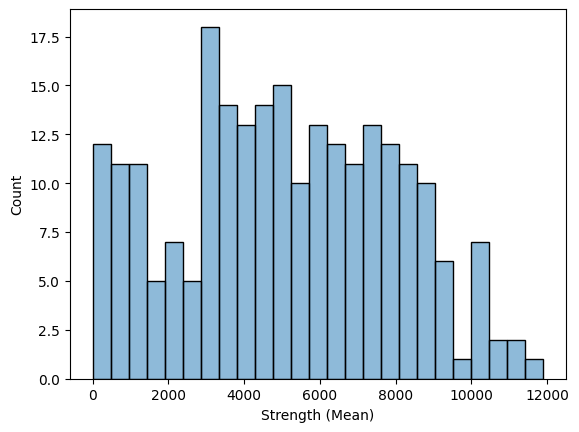

In [4]:
import seaborn as sns

sns.histplot(x = "Strength (Mean)", data = data, bins=25, alpha=0.5,multiple = "stack")

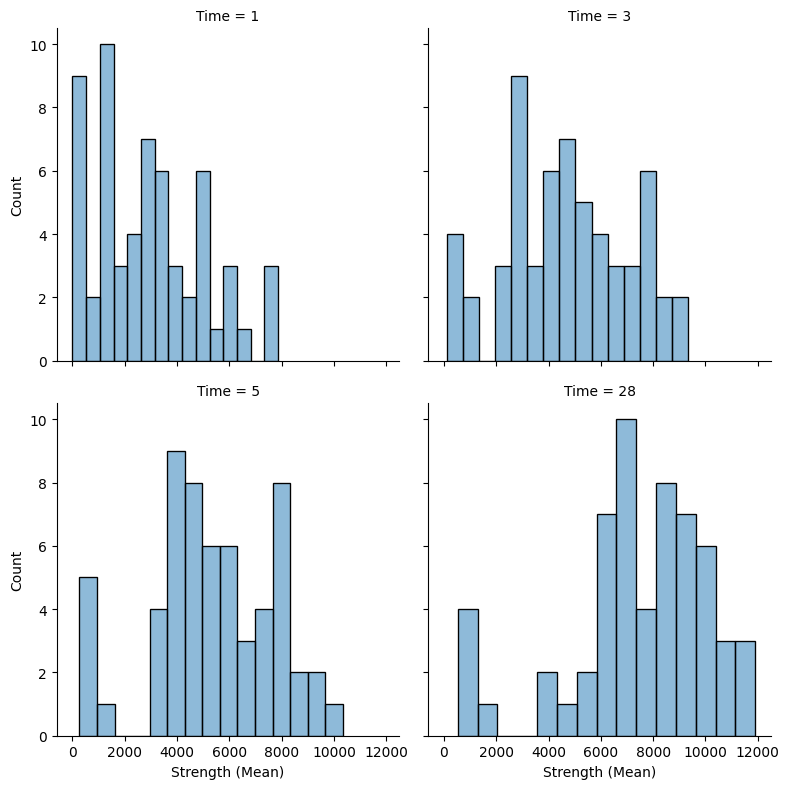

In [5]:
sns.displot(data=data, x='Strength (Mean)', col='Time', col_wrap=2, common_bins=False, height=4,bins=15, alpha = 0.5)

We focus on predicting the strength at 28 days, as we have observed potential outliers within the range of 0 to 2000.


## Apply Robust GP

Question: Can we do better surrogate modelling for BO with robust GP?

In [6]:
!pip install gpflow
import gpflow


from rcgp import RCGPR
from w import IMQ

import matplotlib.pyplot as plt

We focus on the measurements at 28 days.

In [7]:
data_28 = data[data['Time']==28]
X_columns = data.columns[3:-5].to_list()
Y_columns = ["Strength (Mean)"]

In [8]:
X = data_28[X_columns].to_numpy()
Y = data_28[Y_columns].to_numpy()

We use the robust GP proposed by Altamirano et al. 2023

In [9]:
rcgp = RCGPR(
    (X, Y),
    kernel=gpflow.kernels.Matern32(),
    weighting_function= IMQ(C=np.quantile(np.abs(Y), 0.95)),
    noise_variance =1e-4
)
gpflow.set_trainable(rcgp.likelihood.variance, False)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(rcgp.training_loss_closure(), rcgp.trainable_variables, options=opt_options)

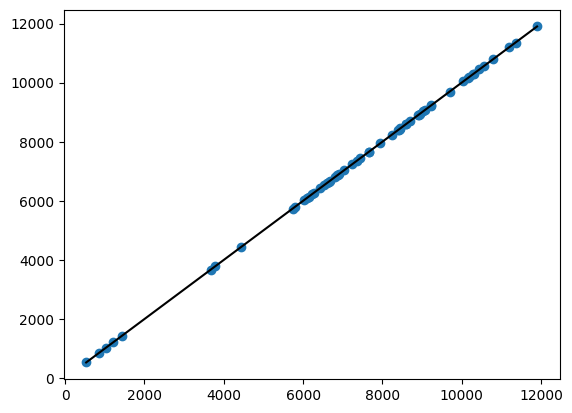

In [10]:
plt.scatter(rcgp.predict_f(X,full_cov=False)[0],Y)
plt.plot(np.linspace(np.min(Y), np.max(Y), 100), np.linspace(np.min(Y), np.max(Y), 100),'k-')

## Get BO Recommendations with robust GP as surrogate model

We first need to define the bounds for our input variables

In [11]:
bounds_dict = {
    "Cement": (0, 950),
    "Fly Ash": (0, 950),
    "Slag": (0, 950),
    "Water" : (35, 475),
    "HRWR": (0, 95),
    "Fine Aggregate": (925, 1775),
    "Curing Temp (°C)": (0, 40),
}
bounds_array = np.array(list(bounds_dict.values()))
dim = X.shape[1]

We use the upper confidence bound as our acquisition function

---



In [12]:
def upperConfidenceBounds(X, gp, kappa=10):

    mu, var = gp.predict_f(X, full_cov=False)
    sigma = np.sqrt(var)

    ucb = mu + kappa * sigma

    return ucb

We find the next step recommendation by maximising the acquisition function

In [13]:
from scipy.optimize import minimize
from scipy.stats import norm

min_val = 1e10
min_x = None

def min_obj(X_next):
    # Minimization objective is the negative acquisition function
    return -upperConfidenceBounds(X_next.reshape(-1, dim), rcgp).numpy().flatten()

# Find the best optimum by starting from n_restart different random points.
for x0 in np.random.uniform(bounds_array[:, 0], bounds_array[:, 1], size=(5, dim)):
    res = minimize(min_obj, x0=x0, bounds=bounds_array, method='L-BFGS-B')
    if res.fun < min_val:
        min_val = res.fun
        min_x = res.x.reshape(1, dim)


In [14]:
print('Recommendation: ')
for i in range(dim):
        print('{} : {:.2f}'.format(X_columns[i], min_x[0][i]))

Recommendation: 
Cement : 775.18
Fly Ash : 109.82
Slag : 696.71
Water : 124.90
HRWR : 7.67
Fine Aggregate : 1015.68
Curing Temp (°C) : 30.85
